In [ ]:
%reload_ext autoreload
%autoreload 3

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', size=12)

import numpy as np
from IPython.display import display

import torch
import pandas as pd
from src.cogponder import CogPonderModel
from src.cogponder.datasets import NBackSRODataset, CogPonderDataModule
from pathlib import Path

In [ ]:
# this notebook only fits one SRO subject, whose SRO-SubjectID can be defined here
SRO_SUBJECT_ID = 202

# upon successful training, the model will be saved to this path
CHECKPOINT_PATH = Path('models/nback/') / f'cogponder_subject-{SRO_SUBJECT_ID}_epochs-10000.ckpt'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Load the dataset and configs

print('Loading N-Back dataset... ', end='')

dataset = NBackSRODataset(n_subjects=-1, response_step_interval=20, non_decision_time='auto')
data = dataset[0]

# determine the number of loaded subjects
n_subjects = data[0].size(1)


n_symbols = torch.unique(data[0]).shape[0]

# parameter space
CONFIG = {
    'task': 'nback',
    'resp_loss_beta': 1.,
    'time_loss_beta': 10.,
    # 'non_decision_time': 10,  # in milliseconds
    'loss_by_trial_type': False,
    'learning_rate': 1e-2,
    'max_response_step': data[4].max().int().item() + 10,
    'inputs_dim': data[0].size(1) - 1,  # minus subject_id (first column)
    'embeddings_dim': n_symbols,
    'outputs_dim': torch.unique(data[3]).size(0),  # number of unique responses
    'auto_lr_find': False,
    'batch_size': 72,
    'n_subjects': 1
}

datamodule = CogPonderDataModule(data,
                                 batch_size=CONFIG['batch_size'],
                                 num_workers=8)
datamodule.prepare_data()

print('Done!')

Loading N-Back dataset... Done!


In [ ]:
# DEBUG

# DEBUG - Load the checkpoint

model_ckpt = CogPonderModel.load_from_checkpoint(CHECKPOINT_PATH)
model_ckpt.eval()

X, trial_types, is_corrects, y_true, rt_true = datamodule.test_dataset[:]

valid_response_mask = (rt_true > 0) & (y_true != 0)

X = X[valid_response_mask, ...]
trial_types = trial_types[valid_response_mask]
y_true = y_true[valid_response_mask]
rt_true = rt_true[valid_response_mask]

with torch.no_grad():
    model_ckpt.eval()

    print('Predicting responses...', end='')
    y_steps,p_halts,rt_pred = model_ckpt(X)

    y_steps = torch.argmax(y_steps, dim=-1)

    y_pred = y_steps.gather(dim=0, index=rt_pred[None, :] - 1,)[0]  # (batch_size,)

    print('Done!')


Predicting responses...Done!


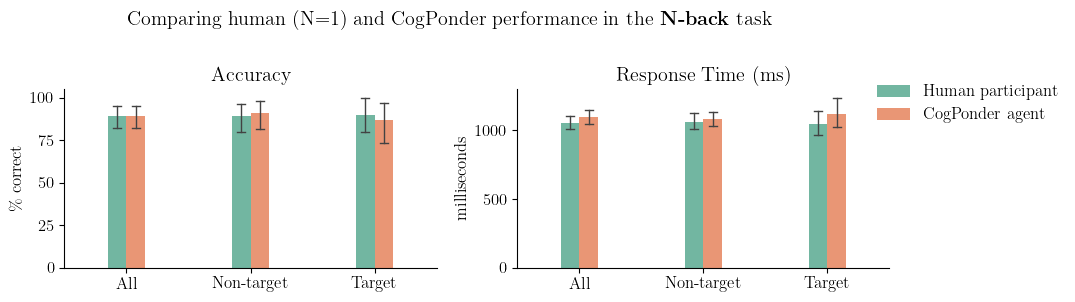

In [ ]:
min_time_step = data[4][data[4]>0].min()

non_decision_time = (
    dataset.non_decision_time[0] + dataset.response_step_interval * min_time_step
)


average_human_performance = pd.DataFrame({
    'condition': -1,
    'response_time': rt_true * dataset.response_step_interval + non_decision_time,
    'accuracy': is_corrects.float() * 100,
    'agent': 'Human participant',
})

human_performance = pd.DataFrame({
    'condition': trial_types.int(),
    'response_time': rt_true * dataset.response_step_interval + non_decision_time,
    'accuracy': is_corrects.float() * 100,
    'agent': 'Human participant',
})

cogponder_performance = pd.DataFrame({
    'condition': trial_types.int(),
    'response_time': rt_pred * dataset.response_step_interval + non_decision_time,
    'accuracy': (y_true == y_pred).float() * 100,
    'agent': 'CogPonder agent'
})

average_cogponder_performance = pd.DataFrame({
    'condition': -1,
    'response_time': rt_pred * dataset.response_step_interval + non_decision_time,
    'accuracy': (y_true == y_pred).float() * 100,
    'agent': 'CogPonder agent',
})

plot_data = pd.concat([human_performance, average_human_performance,
                       cogponder_performance, average_cogponder_performance]).reset_index()

plot_data['response_time'] = plot_data['response_time'] / 1000.0  # to seconds

plot_data['condition'] = plot_data['condition'].map({True: 'Target', False: 'Non-target', -1: 'All'})

plot_data = plot_data.melt(value_vars=['accuracy', 'response_time'], id_vars=['condition', 'agent'])


g = sns.catplot(
    data=plot_data, x='condition', y='value', col='variable', hue='agent',
    kind="bar", height=3, aspect=1.2,
    width=.3, errorbar=('ci', 95), capsize=.065, errwidth=1,
    palette='Set2',
    sharex=False, sharey=False,
    hue_order=['Human participant', 'CogPonder agent'], order=['All', 'Non-target', 'Target'],
    legend=False
)

g.add_legend(loc='upper left', bbox_to_anchor=(.95, .8))

g.axes[0,0].set_ylabel('\% correct')
g.axes[0,0].set_title('Accuracy')
g.axes[0,1].set_ylabel('seconds')
g.axes[0,1].set_title('Response Time (sec)')
g.axes[0,0].set_xlabel(None)
g.axes[0,1].set_xlabel(None)

plt.suptitle('Comparing human (N=1) and CogPonder performance in the \\textbf{N-back} task', y=1)
plt.tight_layout()
plt.savefig('outputs/figures/figure3-nback.png', bbox_inches='tight', dpi=300)
plt.show()

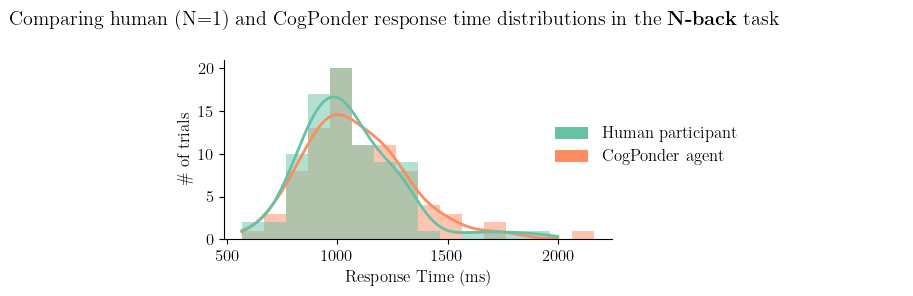

In [ ]:
# Figure 4

plot_data = pd.DataFrame({
    'rt_true': rt_true * dataset.response_step_interval + non_decision_time,
    'rt_pred': rt_pred * dataset.response_step_interval + non_decision_time,
}).melt()

plot_data['value'] = plot_data['value'] / 1000.0  # to seconds

g = sns.displot(
    data=plot_data, x='value', hue='variable',
    kind='hist', kde=True, fill=True, common_norm=False,
    lw=0, alpha=.5, height=3, aspect=1.2,
    kde_kws={'cut': 0, 'clip': (0, 2000)},
    line_kws={'linewidth': 2},
    palette='Set2',
    hue_order=['rt_true', 'rt_pred'],
    legend=True
)

# replace labels
g._legend.set_title(None)
g.legend.set_bbox_to_anchor((1.6, .5))
for t, l in zip(g._legend.texts, ['Human participant', 'CogPonder agent']):
    t.set_text(l)

g._legend.legendHandles[0].set_alpha(1)
g._legend.legendHandles[1].set_alpha(1)

g.ax.set(xlabel='Response Time (sec)', ylabel='\# of trials')

plt.suptitle('Comparing human (N=1) and CogPonder response time distributions in the \\textbf{N-back} task')
plt.tight_layout()
plt.savefig('outputs/figures/figure4-nback.png', bbox_inches='tight', dpi=300)
plt.show()